# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training DCGANs with MNIST dataset, Keras and TensorFlow**

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution, Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*

## 4. Training DCGANs with MNIST dataset,  Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

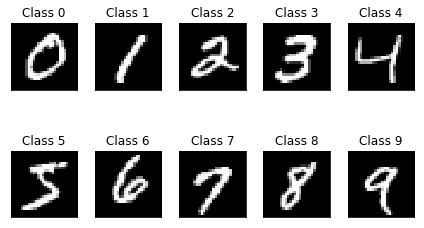

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

#### Discriminator

In [8]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
__________

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [11]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### GAN model vizualization

In [12]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         726401    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 95489     
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


### 4. Fit model

epoch = 1/100, d_loss=1.508, g_loss=10.259                                                                                                                      


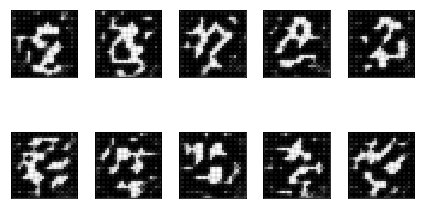

epoch = 2/100, d_loss=1.540, g_loss=10.217                                                                                                                      
epoch = 3/100, d_loss=0.185, g_loss=4.543                                                                                                                       
epoch = 4/100, d_loss=1.283, g_loss=1.491                                                                                                                      
epoch = 5/100, d_loss=0.255, g_loss=3.804                                                                                                                      
epoch = 6/100, d_loss=0.224, g_loss=4.351                                                                                                                      
epoch = 7/100, d_loss=0.202, g_loss=4.537                                                                                                                      
epoch = 8/100, d_loss=0.198, g_loss=4.

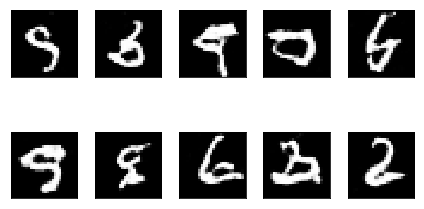

epoch = 12/100, d_loss=0.232, g_loss=4.252                                                                                                                      
epoch = 13/100, d_loss=0.205, g_loss=4.217                                                                                                                      
epoch = 14/100, d_loss=0.197, g_loss=4.614                                                                                                                      
epoch = 15/100, d_loss=0.207, g_loss=4.333                                                                                                                      
epoch = 16/100, d_loss=0.235, g_loss=4.581                                                                                                                      
epoch = 17/100, d_loss=0.192, g_loss=4.847                                                                                                                      
epoch = 18/100, d_loss=0.215, g_lo

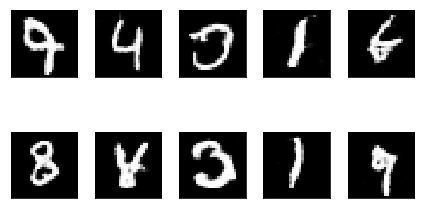

epoch = 22/100, d_loss=0.221, g_loss=3.718                                                                                                                      
epoch = 23/100, d_loss=0.281, g_loss=3.686                                                                                                                      
epoch = 24/100, d_loss=0.220, g_loss=4.132                                                                                                                      
epoch = 25/100, d_loss=0.212, g_loss=4.788                                                                                                                      
epoch = 26/100, d_loss=0.202, g_loss=4.141                                                                                                                      
epoch = 27/100, d_loss=0.196, g_loss=4.862                                                                                                                      
epoch = 28/100, d_loss=0.533, g_lo

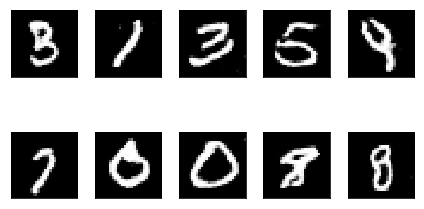

epoch = 32/100, d_loss=0.201, g_loss=4.917                                                                                                                      
epoch = 33/100, d_loss=0.207, g_loss=5.085                                                                                                                      
epoch = 34/100, d_loss=0.187, g_loss=5.238                                                                                                                      
epoch = 35/100, d_loss=0.207, g_loss=5.495                                                                                                                      
epoch = 36/100, d_loss=0.194, g_loss=5.161                                                                                                                      
epoch = 37/100, d_loss=0.196, g_loss=5.639                                                                                                                      
epoch = 38/100, d_loss=0.196, g_lo

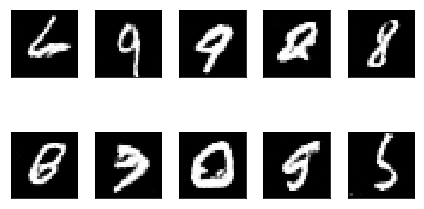

epoch = 42/100, d_loss=0.190, g_loss=5.632                                                                                                                      
epoch = 43/100, d_loss=0.196, g_loss=5.688                                                                                                                      
epoch = 44/100, d_loss=0.197, g_loss=4.805                                                                                                                      
epoch = 45/100, d_loss=0.186, g_loss=6.000                                                                                                                      
epoch = 46/100, d_loss=0.192, g_loss=5.773                                                                                                                      
epoch = 47/100, d_loss=0.209, g_loss=5.290                                                                                                                      
epoch = 48/100, d_loss=0.215, g_lo

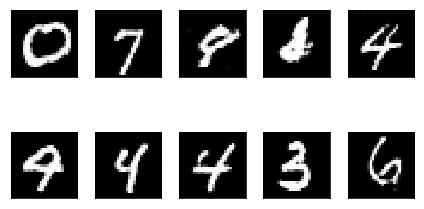

epoch = 52/100, d_loss=0.203, g_loss=4.273                                                                                                                      
epoch = 53/100, d_loss=0.212, g_loss=5.507                                                                                                                      
epoch = 54/100, d_loss=0.201, g_loss=5.222                                                                                                                      
epoch = 55/100, d_loss=0.239, g_loss=6.511                                                                                                                      
epoch = 56/100, d_loss=0.250, g_loss=4.552                                                                                                                      
epoch = 57/100, d_loss=0.197, g_loss=6.627                                                                                                                      
epoch = 58/100, d_loss=0.243, g_lo

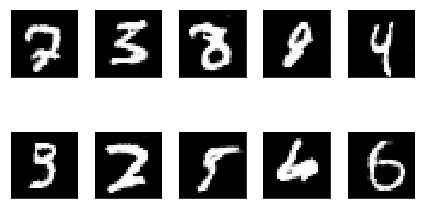

epoch = 62/100, d_loss=0.207, g_loss=4.339                                                                                                                       
epoch = 63/100, d_loss=0.185, g_loss=6.388                                                                                                                      
epoch = 64/100, d_loss=0.255, g_loss=4.887                                                                                                                      
epoch = 65/100, d_loss=0.234, g_loss=5.585                                                                                                                      
epoch = 66/100, d_loss=0.288, g_loss=4.290                                                                                                                      
epoch = 67/100, d_loss=0.234, g_loss=4.920                                                                                                                      
epoch = 68/100, d_loss=0.260, g_l

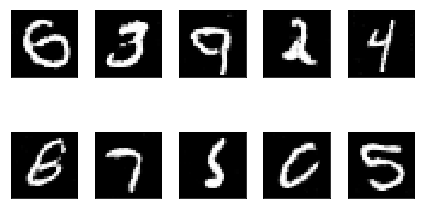

epoch = 72/100, d_loss=0.258, g_loss=6.131                                                                                                                      
epoch = 73/100, d_loss=0.211, g_loss=6.120                                                                                                                      
epoch = 74/100, d_loss=0.325, g_loss=5.433                                                                                                                      
epoch = 75/100, d_loss=0.225, g_loss=5.419                                                                                                                      
epoch = 76/100, d_loss=0.198, g_loss=6.177                                                                                                                      
epoch = 77/100, d_loss=0.386, g_loss=5.269                                                                                                                      
epoch = 78/100, d_loss=0.200, g_lo

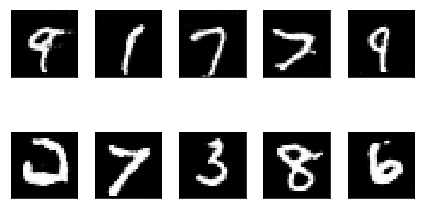

epoch = 82/100, d_loss=0.263, g_loss=5.544                                                                                                                       
epoch = 83/100, d_loss=0.205, g_loss=6.301                                                                                                                      
epoch = 84/100, d_loss=0.246, g_loss=5.431                                                                                                                      
epoch = 85/100, d_loss=0.283, g_loss=6.234                                                                                                                      
epoch = 86/100, d_loss=0.238, g_loss=4.719                                                                                                                      
epoch = 87/100, d_loss=0.240, g_loss=4.682                                                                                                                      
epoch = 88/100, d_loss=0.202, g_l

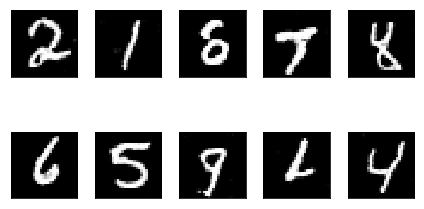

epoch = 92/100, d_loss=0.214, g_loss=6.098                                                                                                                      
epoch = 93/100, d_loss=0.261, g_loss=6.006                                                                                                                      
epoch = 94/100, d_loss=0.268, g_loss=6.796                                                                                                                      
epoch = 95/100, d_loss=0.335, g_loss=5.028                                                                                                                      
epoch = 96/100, d_loss=0.270, g_loss=5.702                                                                                                                      
epoch = 97/100, d_loss=0.192, g_loss=6.074                                                                                                                      
epoch = 98/100, d_loss=0.610, g_lo

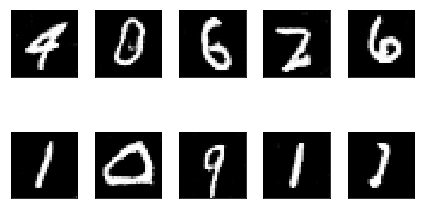

In [15]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

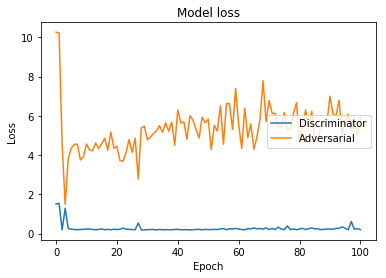

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)